In [1]:
import pandas as pd 
from sklearn.utils import class_weight

In [2]:
df = pd.read_csv('/run/media/twoaday/data-storag/data-sets/fashion-product-images-small/styles.csv', error_bad_lines=False)
df = df.dropna()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
df.loc[df.usage == 'Smart Casual'].head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
1104,27870,Women,Apparel,Topwear,Shirts,White,Fall,2012.0,Smart Casual,Scullers For Her Women White Striped Shirt
4263,11324,Men,Apparel,Bottomwear,Trousers,Black,Fall,2011.0,Smart Casual,United Colors of Benetton Men Black and Brown ...
5860,20715,Men,Footwear,Shoes,Casual Shoes,Black,Winter,2018.0,Smart Casual,Red Tape Men Black Leather Casual Shoes
6440,59986,Women,Apparel,Dress,Dresses,Black,Fall,2012.0,Smart Casual,Avirate Women Black Dress
6486,46536,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Smart Casual,Timex Men Black Dial Watch


In [4]:
df.groupby('usage').count()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,productDisplayName
usage,,,,,,,,,
Casual,34397,34397,34397,34397,34397,34397,34397,34397,34397
Ethnic,3208,3208,3208,3208,3208,3208,3208,3208,3208
Formal,2345,2345,2345,2345,2345,2345,2345,2345,2345
Home,1,1,1,1,1,1,1,1,1
Party,29,29,29,29,29,29,29,29,29
Smart Casual,67,67,67,67,67,67,67,67,67
Sports,4004,4004,4004,4004,4004,4004,4004,4004,4004
Travel,26,26,26,26,26,26,26,26,26


In [5]:
df.loc[df.usage == 'usage']

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName


In [6]:
classes = sorted(df.usage.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.usage)
list(zip(classes, weights))

[('Casual', 0.16017748640869844),
 ('Ethnic', 1.7174641521197007),
 ('Formal', 2.3495202558635393),
 ('Home', 5509.625),
 ('Party', 189.98706896551724),
 ('Smart Casual', 82.23320895522389),
 ('Sports', 1.3760302197802199),
 ('Travel', 211.90865384615384)]

In [7]:
df.usage = df.usage.replace({'Smart Casual': 'Casual'})
df.usage = df.usage.replace({'Home': 'Other', 'Travel': 'Other', 'Party': 'Other'})
df.groupby('usage').count()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,productDisplayName
usage,,,,,,,,,
Casual,34464,34464,34464,34464,34464,34464,34464,34464,34464
Ethnic,3208,3208,3208,3208,3208,3208,3208,3208,3208
Formal,2345,2345,2345,2345,2345,2345,2345,2345,2345
Other,56,56,56,56,56,56,56,56,56
Sports,4004,4004,4004,4004,4004,4004,4004,4004,4004


In [8]:
classes = sorted(df.usage.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.usage)
list(zip(classes, weights))

[('Casual', 0.255785747446611),
 ('Ethnic', 2.747942643391521),
 ('Formal', 3.759232409381663),
 ('Other', 157.41785714285714),
 ('Sports', 2.201648351648352)]

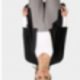

In [53]:
import matplotlib.image as mpimg
import imgaug.augmenters as iaa
import numpy as np

from keras.preprocessing import image
from commons.image_utils import scale_image

from PIL import Image

aug = iaa.Sequential([
        iaa.Crop(px=(0, 16)),  # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5),  # horizontally flip 50% of the images
        iaa.Flipud(0.5),  # vertically flip 50% of the images
        iaa.GaussianBlur(sigma=(0., 2.))  # blur images with a sigma of 0 to 3.0
])

f = open('/run/media/twoaday/data-storag/data-sets/fashion-product-images-small/images/1165.jpg', 'rb')
f = Image.open(f)
f = scale_image(f, [80, 80])
f = np.asarray(f)
img_data = image.img_to_array(f)
img_data = np.expand_dims(img_data, axis=0)
img_data = img_data.astype('float32') / 255.
img_data = np.clip(img_data, 0., 1.)
img_data = img_data[0]
img_data = aug.augment_image(img_data)
# Creates PIL image
img = Image.fromarray(np.uint8(img_data * 255))
img

In [54]:
img_data.shape

(80, 80, 3)